In [ ]:
import sys
import os

!git clone https://github.com/komalniraula/adaptive-inference-llm

repo_name = 'adaptive-inference-llm' # Must match the folder created by git clone
project_path = os.path.join('/content', repo_name)

# Append the project root directory to the system path

sys.path.append(project_path)

Cloning into 'adaptive-inference-llm'...
remote: Enumerating objects: 274, done.
remote: Counting objects: 100% (274/274), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 274 (delta 133), reused 210 (delta 71), pack-reused 0 (from 0)
Receiving objects: 100% (274/274), 6.42 MiB | 20.17 MiB/s, done.
Resolving deltas: 100% (133/133), done.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import pandas as pd
import time

In [ ]:
class GPT2EarlyExitClassifier(nn.Module):
    def __init__(self, model_name, exit_layers, threshold, verbalizers, device):
        super().__init__()

        self.device = device

        self.model = AutoModelForCausalLM.from_pretrained(model_name).to(self.device)
        self.model.eval()

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        # GPT-2 components
        self.wte = self.model.transformer.wte          # word embeddings
        self.wpe = self.model.transformer.wpe          # position embeddings
        self.h = self.model.transformer.h              # list of transformer blocks
        self.ln_f = self.model.transformer.ln_f        # final layer norm
        self.lm_head = self.model.lm_head              # language modeling head

        self.num_layers = len(self.h)

        self.exit_layers = sorted(exit_layers)
        self.threshold = threshold
        self.verbalizers = verbalizers

        # Precompute token IDs of verbalizers
        self.verbalizer_token_ids = {}
        for dataset, class_map in verbalizers.items():
            tok_ids_map = {}
            for cls, words in class_map.items():
                token_lists = []
                for w in words:
                    ids = self.tokenizer.encode(" " + w, add_special_tokens=False)
                    token_lists.append(ids)
                tok_ids_map[cls] = token_lists
            self.verbalizer_token_ids[dataset] = tok_ids_map

    @torch.no_grad()
    def classify(self, text, dataset_name):

        # Convert to input IDs
        # Convert to input IDs
        inputs = self.tokenizer(text, return_tensors="pt").to(self.device)
        input_ids = inputs["input_ids"]
        seq_len = input_ids.shape[1]
        last_index = seq_len - 1

        # --- STEP 1: Compute embeddings ---
        position_ids = torch.arange(0, seq_len, dtype=torch.long).unsqueeze(0).to(self.device)
        hidden = self.wte(input_ids) + self.wpe(position_ids)

        verbalizer_map = self.verbalizer_token_ids[dataset_name]

        # --- STEP 2: Iterate through GPT-2 blocks, EXIT EARLY WHEN POSSIBLE ---
        for layer_idx, block in enumerate(self.h):

            # Pass through one transformer layer
            hidden = block(hidden)[0]

            # If this is an early-exit layer → run classification
            if (layer_idx + 1) in self.exit_layers:
                cls_vec = hidden[:, last_index, :]      # [1, hidden_dim]
                logits = self.lm_head(cls_vec)[0]       # per-token logits

                # Compute class scores using verbalizers
                class_scores = []
                for cls, tok_lists in verbalizer_map.items():
                    vals = []
                    for tok_list in tok_lists:
                        idx = torch.tensor(tok_list, dtype=torch.long).to(self.device)
                        vals.append(logits[idx].mean().item())
                    class_scores.append(np.mean(vals))

                class_scores = torch.tensor(class_scores)
                probs = torch.softmax(class_scores, dim=-1)
                pred = int(torch.argmax(probs))
                conf = float(probs[pred])

                # TRUE EARLY EXIT
                if conf > self.threshold:
                    return pred, layer_idx + 1, conf

        # --- STEP 3: FINAL EXIT (after all layers) ---
        hidden = self.ln_f(hidden)
        cls_vec = hidden[:, last_index, :]
        logits = self.lm_head(cls_vec)[0]

        class_scores = []
        for cls, tok_lists in verbalizer_map.items():
            vals = []
            for tok_list in tok_lists:
                idx = torch.tensor(tok_list, dtype=torch.long)
                vals.append(logits[idx].mean().item())
            class_scores.append(np.mean(vals))

        class_scores = torch.tensor(class_scores)
        probs = torch.softmax(class_scores, dim=-1)
        pred = int(torch.argmax(probs))
        conf = float(probs[pred])

        return pred, self.num_layers, conf

In [ ]:
# ---------------------------------------
# BASELINE classifier (FINAL LAYER ONLY)
# ---------------------------------------
class GPT2BaselineClassifier(torch.nn.Module):
    def __init__(self, model_name, verbalizers, device):
        super().__init__()

        self.device = device

        self.model = AutoModelForCausalLM.from_pretrained(
            model_name, output_hidden_states=True
        ).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.verbalizers = verbalizers
        self.num_layers = len(self.model.transformer.h)

        # Precompute tokens
        self.verbalizer_token_ids = {}
        for dataset, class_map in verbalizers.items():
            ids = {}
            for cls, words in class_map.items():
                tok_list = self.tokenizer.encode(" " + words[0])
                ids[cls] = tok_list
            self.verbalizer_token_ids[dataset] = ids

    @torch.no_grad()
    def classify(self, text, dataset_name):
        inputs = self.tokenizer(text, return_tensors="pt")
        input_ids = inputs["input_ids"].to(self.device)

        outputs = self.model(input_ids, output_hidden_states=True)
        hidden = outputs.hidden_states[self.num_layers][:, -1, :]

        logits = self.model.lm_head(hidden)[0]

        class_verbalizers = self.verbalizer_token_ids[dataset_name]
        scores = []

        for cls, tok_list in class_verbalizers.items():
            idx = torch.tensor(tok_list, dtype=torch.long).to(self.device)
            scores.append(logits[idx].mean().item())

        scores = torch.tensor(scores)
        probs = torch.softmax(scores, dim=-1)

        pred = int(torch.argmax(probs))
        return pred, self.num_layers, float(probs[pred])

In [ ]:
from evaluation.dataset_loaders.sst2 import load_sst2

# ---------------------------------------
# Verbalyzers for GPT-2 classification
verbalizers = {
    "sst2": {
        0: ["negative"],
        1: ["positive"],
    }
}

dataset_loaders = [
    ("sst2", load_sst2, "classification")
]

cached_datasets = {}
print("Loading datasets once...\n")

for name, loader, task in dataset_loaders:
    print(f"Loading {name}...")
    cached_datasets[name] = {
        "data": loader(fraction=1),
        "task": task
    }

for data in cached_datasets:
    print(f"Length of the {data} dataset: {len(cached_datasets[data]['data'])}")

print("\nAll datasets loaded.\n")

Loading datasets once...

Loading sst2...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Length of the sst2 dataset: 872

All datasets loaded.



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ---------------------------------------
# Extract (text, label) from any format
# ---------------------------------------
def extract_text_label(sample):
    if isinstance(sample, dict):
        if "text" in sample:
            return sample["text"], sample["label"]
        elif "sentence" in sample:
            return sample["sentence"], sample["label"]
        elif "input_text" in sample:
            return sample["input_text"], sample["label"]
        else:
            raise ValueError("Unknown dict format:", sample)

    if isinstance(sample, (tuple, list)):
        return sample[0], sample[1]

    raise ValueError("Unknown sample format:", sample)


# ---------------------------------------
# Evaluation
# ---------------------------------------
def evaluate_dataset(model, dataset, dataset_name):
    correct = 0
    total = 0
    layers_used = []
    total_tokens = 0

    start = time.time()

    for sample in dataset:
        text, label = extract_text_label(sample)

        pred, layer, conf = model.classify(text, dataset_name)

        correct += (pred == label)
        total += 1
        layers_used.append(layer)

        total_tokens += len(model.tokenizer(text)["input_ids"])

    end = time.time()
    latency = (end - start) / total

    return {
        "metric": "accuracy",
        "score": correct / total,
        "avg_latency_sec": latency,
        "tokens_per_sec": total_tokens / (end - start),
        "avg_layers_used": float(np.mean(layers_used)),
        "num_samples": total
    }

In [ ]:
# ---------------------------------------
# Run baseline + early exit
# ---------------------------------------
results_table = []

# -------------------------
# BASELINE FIRST
# -------------------------
print("\n==============================")
print("Running BASELINE")
print("==============================")

baseline_model = GPT2BaselineClassifier(
    model_name="gpt2-medium",
    verbalizers=verbalizers,
    device = device
).to(device)

for name, meta in cached_datasets.items():
    dataset = meta["data"]
    print(f"\nTesting BASELINE on {name}...")

    result = evaluate_dataset(baseline_model, dataset, name)
    print(name, result)

    results_table.append({
        "dataset": name,
        "threshold": None,
        "mode": "baseline",
        "metric": result["metric"],
        "score": float(result["score"]),
        "avg_latency_sec": float(result["avg_latency_sec"]),
        "tokens_per_sec": float(result["tokens_per_sec"]),
        "avg_layers_used": float(result["avg_layers_used"]),
        "num_samples": int(result["num_samples"]),
    })


Running BASELINE


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


Testing BASELINE on sst2...
sst2 {'metric': 'accuracy', 'score': 0.7075688073394495, 'avg_latency_sec': 0.02095358169406926, 'tokens_per_sec': 1145.8267451584284, 'avg_layers_used': 24.0, 'num_samples': 872}


In [ ]:
# -------------------------
# EARLY EXIT NEXT
# -------------------------
exit_layer_groups = [
    [3, 6, 9, 12, 15, 18, 21],
    [6, 12, 18],
    [5, 10, 15, 20],
    [12]
]

thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for exit_layers in exit_layer_groups:

    print("\n=================================================")
    print(f"Testing EXIT LAYERS: {exit_layers}")
    print("=================================================")

    for th in thresholds:

        print(f"\n----------------------------")
        print(f"Threshold = {th}")
        print(f"Exit Layers = {exit_layers}")
        print("----------------------------")

        # Build model with these exit layers + threshold
        model = GPT2EarlyExitClassifier(
            model_name="gpt2-medium",
            exit_layers=exit_layers,
            threshold=th,
            verbalizers=verbalizers,
            device=device
        ).to(device)

        # Evaluate across datasets
        for name, meta in cached_datasets.items():
            dataset = meta["data"]

            print(f"\nTesting {name} (exit_layers={exit_layers}, threshold={th})...")

            result = evaluate_dataset(model, dataset, name)
            print(name, result)

            # Save results with exit_layers column added
            results_table.append({
                "dataset": name,
                "threshold": th,
                "exit_layers": str(exit_layers),       # <<< NEW COLUMN
                "mode": "early_exit",
                "metric": result["metric"],
                "score": float(result["score"]),
                "tokens_per_sec": float(result["tokens_per_sec"]),
                "avg_latency_sec": float(result["avg_latency_sec"]),
                "avg_layers_used": float(result["avg_layers_used"]),
                "num_samples": int(result["num_samples"]),
            })


Testing EXIT LAYERS: [3, 6, 9, 12, 15, 18, 21]

----------------------------
Threshold = 0.5
Exit Layers = [3, 6, 9, 12, 15, 18, 21]
----------------------------

Testing sst2 (exit_layers=[3, 6, 9, 12, 15, 18, 21], threshold=0.5)...
sst2 {'metric': 'accuracy', 'score': 0.4908256880733945, 'avg_latency_sec': 0.003437798231019886, 'tokens_per_sec': 6983.881164196144, 'avg_layers_used': 3.0, 'num_samples': 872}

----------------------------
Threshold = 0.6
Exit Layers = [3, 6, 9, 12, 15, 18, 21]
----------------------------

Testing sst2 (exit_layers=[3, 6, 9, 12, 15, 18, 21], threshold=0.6)...
sst2 {'metric': 'accuracy', 'score': 0.4908256880733945, 'avg_latency_sec': 0.0035696737810012396, 'tokens_per_sec': 6725.87350690415, 'avg_layers_used': 3.0, 'num_samples': 872}

----------------------------
Threshold = 0.7
Exit Layers = [3, 6, 9, 12, 15, 18, 21]
----------------------------

Testing sst2 (exit_layers=[3, 6, 9, 12, 15, 18, 21], threshold=0.7)...
sst2 {'metric': 'accuracy', 'scor

In [ ]:
df=pd.DataFrame(results_table)
df

,dataset,threshold,mode,metric,score,avg_latency_sec,tokens_per_sec,avg_layers_used,num_samples,exit_layers
0,sst2,NaN,baseline,accuracy,0.707569,0.020954,1145.826745,24.000000,872,NaN
1,sst2,0.5,early_exit,accuracy,0.490826,0.003438,6983.881164,3.000000,872,"[3, 6, 9, 12, 15, 18, 21]"
2,sst2,0.6,early_exit,accuracy,0.490826,0.003570,6725.873507,3.000000,872,"[3, 6, 9, 12, 15, 18, 21]"
3,sst2,0.7,early_exit,accuracy,0.490826,0.003442,6975.128911,3.000000,872,"[3, 6, 9, 12, 15, 18, 21]"
4,sst2,0.8,early_exit,accuracy,0.490826,0.003483,6893.253925,3.000000,872,"[3, 6, 9, 12, 15, 18, 21]"
5,sst2,0.9,early_exit,accuracy,0.490826,0.003450,6959.918507,3.000000,872,"[3, 6, 9, 12, 15, 18, 21]"
6,sst2,1.0,early_exit,accuracy,0.707569,0.022097,1086.521650,24.000000,872,"[3, 6, 9, 12, 15, 18, 21]"
7,sst2,0.5,early_exit,accuracy,0.569954,0.005520,4349.310941,6.000000,872,"[6, 12, 18]"
8,sst2,0.6,early_exit,accuracy,0.552752,0.005990,4008.224440,6.784404,872,"[6, 12, 18]"
9,sst2,0.7,early_exit,accuracy,0.540138,0.006814,3523.442331,7.720183,872,"[6, 12, 18]"


In [ ]:
df_sst2 = df[(df["dataset"] == "sst2")]
df_sst2[['mode', 'score', 'avg_latency_sec', 'tokens_per_sec', 'threshold', 'exit_layers']]

,mode,score,avg_latency_sec,tokens_per_sec,threshold,exit_layers
0,baseline,0.707569,0.020954,1145.826745,NaN,NaN
1,early_exit,0.490826,0.003438,6983.881164,0.5,"[3, 6, 9, 12, 15, 18, 21]"
2,early_exit,0.490826,0.003570,6725.873507,0.6,"[3, 6, 9, 12, 15, 18, 21]"
3,early_exit,0.490826,0.003442,6975.128911,0.7,"[3, 6, 9, 12, 15, 18, 21]"
4,early_exit,0.490826,0.003483,6893.253925,0.8,"[3, 6, 9, 12, 15, 18, 21]"
5,early_exit,0.490826,0.003450,6959.918507,0.9,"[3, 6, 9, 12, 15, 18, 21]"
6,early_exit,0.707569,0.022097,1086.521650,1.0,"[3, 6, 9, 12, 15, 18, 21]"
7,early_exit,0.569954,0.005520,4349.310941,0.5,"[6, 12, 18]"
8,early_exit,0.552752,0.005990,4008.224440,0.6,"[6, 12, 18]"
9,early_exit,0.540138,0.006814,3523.442331,0.7,"[6, 12, 18]"


In [ ]:
df_sst2 = df[(df["dataset"] == "sst2") & (df["avg_latency_sec"] < 0.020)]
df_sst2[['mode', 'score', 'avg_latency_sec', 'exit_layers']]

,mode,score,avg_latency_sec,exit_layers
1,early_exit,0.490826,0.003438,"[3, 6, 9, 12, 15, 18, 21]"
2,early_exit,0.490826,0.003570,"[3, 6, 9, 12, 15, 18, 21]"
3,early_exit,0.490826,0.003442,"[3, 6, 9, 12, 15, 18, 21]"
4,early_exit,0.490826,0.003483,"[3, 6, 9, 12, 15, 18, 21]"
5,early_exit,0.490826,0.003450,"[3, 6, 9, 12, 15, 18, 21]"
7,early_exit,0.569954,0.005520,"[6, 12, 18]"
8,early_exit,0.552752,0.005990,"[6, 12, 18]"
9,early_exit,0.540138,0.006814,"[6, 12, 18]"
10,early_exit,0.533257,0.007778,"[6, 12, 18]"
11,early_exit,0.551606,0.009397,"[6, 12, 18]"


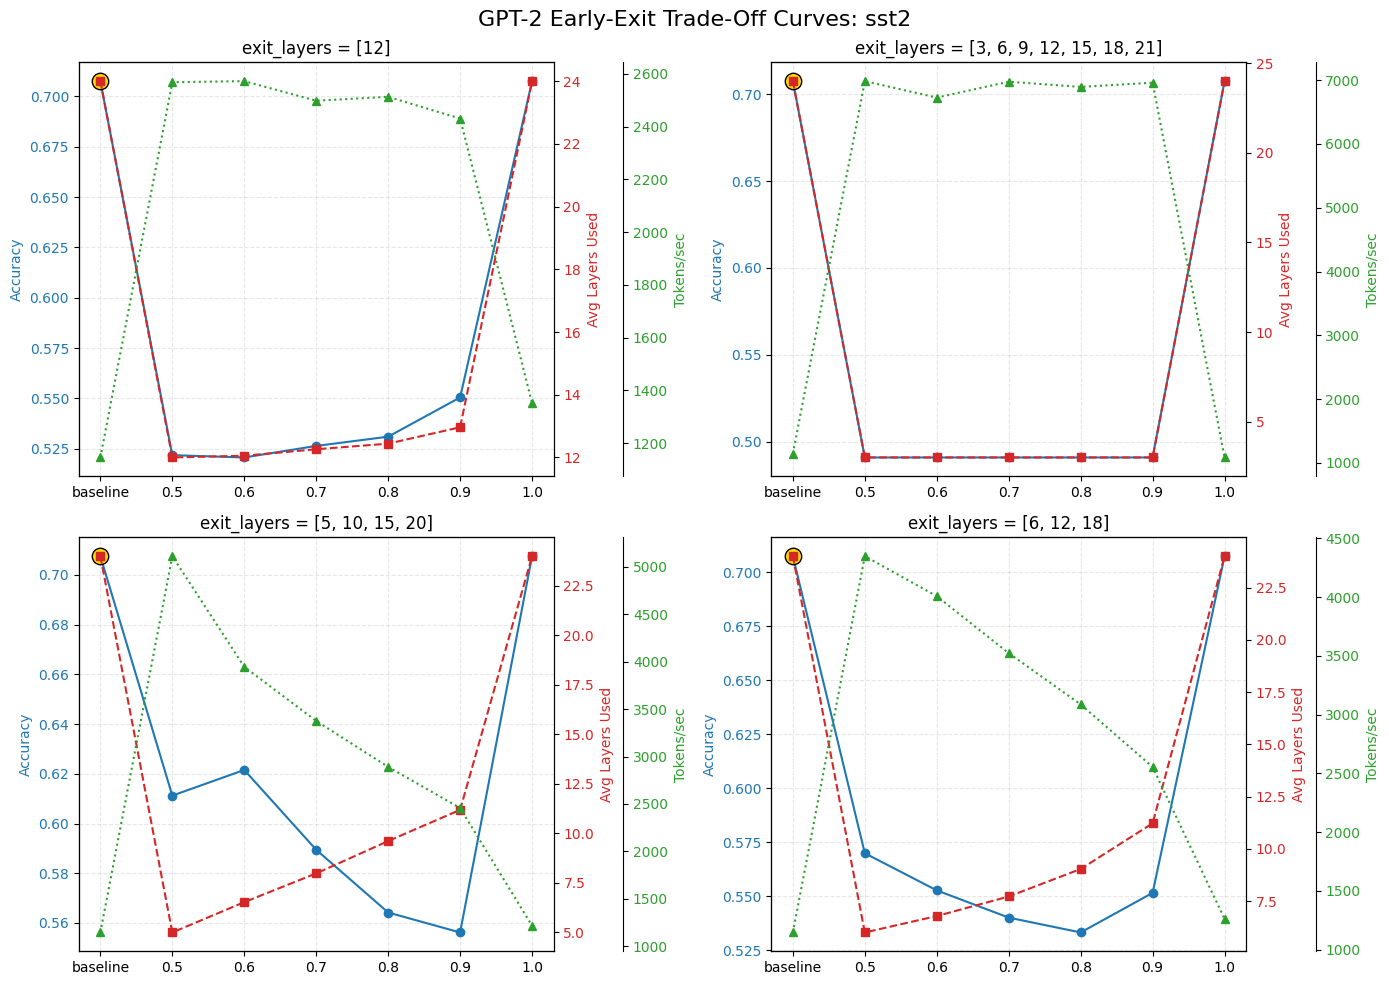

In [ ]:
# Plotting
import matplotlib.pyplot as plt
import math

df2 = df.copy()

# Replace NaN thresholds with 'baseline'
df2['threshold'] = df2['threshold'].apply(
    lambda x: "baseline" if pd.isna(x) else x
)

# Convert exit_layers list → string for grouping
df2['exit_layers_str'] = df2['exit_layers'].apply(lambda x: str(x))

datasets = df2['dataset'].unique()

for ds in datasets:

    df_ds = df2[df2['dataset'] == ds]

    # Get all exit_layers configs EXCEPT baseline
    exit_configs = sorted(df_ds['exit_layers_str'].unique())
    exit_configs = [cfg for cfg in exit_configs if cfg != "nan"]

    # Only keep configs that are real lists (not baseline)
    # ensure exactly 4 for plotting (or fewer → still works)
    exit_configs = exit_configs[:4]

    # Prepare 2×2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    # Extract baseline row(s)
    df_base = df_ds[df_ds['mode'] == "baseline"]

    # ---------- LOOP OVER EXIT CONFIGS ----------
    for idx, exit_cfg in enumerate(exit_configs):

        ax = axes[idx]

        # Subset for this exit layers
        df_sub = df_ds[df_ds['exit_layers_str'] == exit_cfg]

        ###########################################
        # 1) Extract values (early-exit run)
        ###########################################
        # Early exit values
        thresholds = df_sub['threshold'].tolist()
        scores     = df_sub['score'].tolist()
        layers     = df_sub['avg_layers_used'].tolist()
        tps        = df_sub['tokens_per_sec'].tolist()

        # Add baseline explicitly (first element)
        if not df_base.empty:
            thresholds = ["baseline"] + thresholds
            scores     = [df_base['score'].iloc[0]] + scores
            layers     = [df_base['avg_layers_used'].iloc[0]] + layers
            tps        = [df_base['tokens_per_sec'].iloc[0]] + tps


        ###########################################
        # 2) Extract baseline values
        ###########################################
        base_thresholds = df_base['threshold'].tolist()
        base_scores     = df_base['score'].tolist()
        base_layers     = df_base['avg_layers_used'].tolist()
        base_tps        = df_base['tokens_per_sec'].tolist()

        # ---- Sorting helper: baseline always first ----
        def sort_key(x):
            return -1 if x == "baseline" else float(x)

        sorted_idx = sorted(
            range(len(thresholds)),
            key=lambda i: sort_key(thresholds[i])
        )

        thresholds = [thresholds[i] for i in sorted_idx]
        scores     = [scores[i]     for i in sorted_idx]
        layers     = [layers[i]     for i in sorted_idx]
        tps        = [tps[i]        for i in sorted_idx]

        x_pos = np.arange(len(thresholds))

        ################################################
        # ---- PLOTS (same style as your original) ----
        ################################################
        ax1 = ax

        # Accuracy curve
        ax1.plot(x_pos, scores, marker="o", color="tab:blue", label="Accuracy")
        ax1.set_ylabel("Accuracy", color="tab:blue")
        ax1.tick_params(axis="y", labelcolor="tab:blue")

        # Plot baseline point in gold
        for i, th in enumerate(thresholds):
            if th == "baseline":
                ax1.scatter(
                    x_pos[i], scores[i],
                    color="gold", s=140, edgecolor="black", zorder=6,
                    label="Baseline"
                )

        # Avg layers
        ax2 = ax1.twinx()
        ax2.plot(
            x_pos, layers,
            marker="s", linestyle="--",
            color="tab:red", label="Layers Used"
        )
        ax2.set_ylabel("Avg Layers Used", color="tab:red")
        ax2.tick_params(axis="y", labelcolor="tab:red")

        # Tokens/sec
        ax3 = ax1.twinx()
        ax3.spines["right"].set_position(("outward", 50))
        ax3.plot(
            x_pos, tps,
            marker="^", linestyle=":",
            color="tab:green", label="Tokens/sec"
        )
        ax3.set_ylabel("Tokens/sec", color="tab:green")
        ax3.tick_params(axis="y", labelcolor="tab:green")

        ax.set_xticks(x_pos)
        ax.set_xticklabels(thresholds)
        ax.set_title(f"exit_layers = {exit_cfg}")

        ax.grid(True, linestyle="--", alpha=0.3)

    # ------- FIGURE TITLE -------
    fig.suptitle(f"GPT-2 Early-Exit Trade-Off Curves: {ds}", fontsize=16)
    plt.tight_layout()
    plt.show()